<a href="https://colab.research.google.com/github/AnIsAsPe/Estadistica_y_Probabilidad_para-CD-/blob/main/Semana8/Notebooks/Red_Bayesiana_Sobrevivientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyagrum  # permite utilizar biblioteca C++ aGrUM

     |████████████████████████████████| 5.2 MB 5.1 MB/s 


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Modeloando las características de los sobrevivientes del Titanic

In [3]:
bn = gum.BayesNet("Sobrevivientes")
bn =gum.fastBN("Age;Gender;Relatives; Pclass; Embarked; Survived")

bn

(pyAgrum.BayesNet<double>@0x559b4af90600) BN{nodes: 6, arcs: 0, domainSize: 64, dim: 12}

De lo que sabemos del Titanic ¿qué modelo gráfico podríamos construir para explicar la sobrevivencia de los pasajeros?

In [4]:
bn =gum.fastBN("Age;Gender->Survived<-Pclass<-Embarked ;Relatives")

bn

(pyAgrum.BayesNet<double>@0x559b4af90c00) BN{nodes: 6, arcs: 3, domainSize: 64, dim: 20}

## Modelo bayesiano que aprende de un conjunto de datos

El conjunto de datos tiene su origen en los datos ofrecidos por [Kaggle](https://www.kaggle.com/c/titanic/data). 



In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
import pandas as pd
datos = pd.read_csv('/content/titanic_rb.csv')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Survived   1309 non-null   bool  
 1   Pclass     1309 non-null   int64 
 2   Gender     1309 non-null   object
 3   Age        1309 non-null   object
 4   Embarked   1307 non-null   object
 5   Relatives  1309 non-null   bool  
dtypes: bool(2), int64(1), object(3)
memory usage: 43.6+ KB


In [50]:
for col in datos:
    print(datos[col].value_counts(), end='\n\n')

False    815
True     494
Name: Survived, dtype: int64

3    709
1    323
2    277
Name: Pclass, dtype: int64

Male      843
Female    466
Name: Gender, dtype: int64

adult      796
old        264
teen       158
toddler     44
kid         35
baby        12
Name: Age, dtype: int64

S    914
C    270
Q    123
Name: Embarked, dtype: int64

False    790
True     519
Name: Relatives, dtype: int64



In [65]:
learner = gum.BNLearner('/content/titanic_rb.csv')
bn = learner.learnBN()
bn

(pyAgrum.BayesNet<double>@0x559b4b022a00) BN{nodes: 6, arcs: 8, domainSize: 576, dim: 94}

La red muestra las dependencias probabilísticas entre las variables, así como las independencias condicionales de una variable dada(s) otra(s) variable(s). 

$\mathbb{P} ( S\mid G,PC,E,A,R ) = \mathbb{P}( S\mid G,PC)$

$\mathbb{P} ( G\mid PC,E, A,R ) = \mathbb{P}( G\mid E,R)$

In [66]:
print(bn.variable("Age"))

Age:Labelized(<adult,baby,kid,old,teen,toddler>)


### Exploración de datos.


Podemos ver la tabla de probabilidad condicional de cada variable

In [55]:
bn.cpt('Survived') 

(pyAgrum.Potential<double>@0x559b49a019e0) 
             ||  Survived         |
Gender|Pclass||False    |True     |
------|------||---------|---------|
Female|1     || 0.0214  | 0.9786  |
Male  |1     || 0.7484  | 0.2516  |
Female|2     || 0.0573  | 0.9427  |
Male  |2     || 0.9002  | 0.0998  |
Female|3     || 0.3335  | 0.6665  |
Male  |3     || 0.9045  | 0.0955  |

In [28]:
bn.cpt('Gender')

(pyAgrum.Potential<double>@0x559b4b5caa20) 
             ||  Gender           |
Relati|Embark||Female   |Male     |
------|------||---------|---------|
False |      || 0.9706  | 0.0294  |
True  |      || 0.5000  | 0.5000  |
False |C     || 0.2965  | 0.7035  |
True  |C     || 0.5407  | 0.4593  |
False |Q     || 0.4898  | 0.5102  |
True  |Q     || 0.4801  | 0.5199  |
False |S     || 0.1875  | 0.8125  |
True  |S     || 0.5209  | 0.4791  |

C = Cherbourg, Q = Queenstown, S = Southampton

y la distribución de cada variable en nuestra base de datos

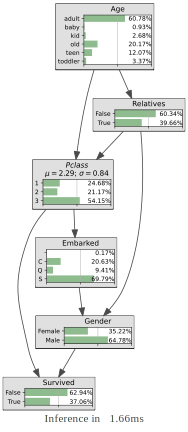

In [56]:
gnb.showInference(bn,evs={}, size="6") 

### Inferencia (propagación de probabilidades)

Propagación los efectos de la evidencia a través de la red para conocer la probabilidad a posteriori de las variables dadas las variables conocidas

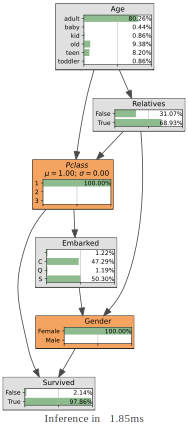

In [57]:
gnb.showInference(bn,evs={"Gender": "Female", "Pclass": "1"}, size="6") 

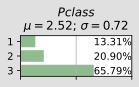

In [58]:
#Probabilidad de la clase en la que viajan los adolecentes.
gnb.showPosterior(bn,evs={ "Age": 'teen'},target='Pclass')

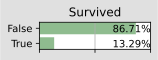

In [59]:
# Probabilidad de sobrevivencia de los Hombres adultos:

gnb.showPosterior(bn,evs={"Gender": "Male"},target='Survived')

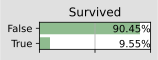

In [60]:
# Probabilidad de sobrevivencia de los adolescentes en tercera clase:

gnb.showPosterior(bn,evs={"Gender": "Male", "Age": "teen", "Pclass": "3"},target='Survived')

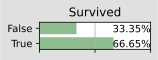

In [61]:
#Probabilidad de sobrevivencia de las mujeres en tercera clase:
gnb.showPosterior(bn,evs={"Gender": "Female", "Pclass": "3"},target='Survived')

In [62]:
gum.saveBN(bn, "RedBayesiana_titanic.bif")

## Modelo bayesiano a partir de conocimiento previo

Empezamos por dibujar una red bayesiana simple, con las siguientes hipótesis:

* La unica variable que está condicionada a cada una de las demás es la sobrevivncia, las demás son independientes entre sí.
*Mujeres y niños tienen más posibilidades de sobrevivir.
* Si tienen parientes abordo, hay menos probabilidades de sobrevivencia.

In [ ]:
# creamos el modelo donde la variable dependiente (Sobreviviencia) esta
# condicionada a las otras variables que son independientes entre ellas
bn = gum.BayesNet("Sobrevivientes")
bn =gum.fastBN("Edad{menor|adulto|mayor}<-Sobrevivencia{No|Sí}->Sexo{Mujer|Hombre};Familiares{No|Sí}<-Sobrevivencia")
print(bn.variable("Sobrevivencia"))
print(bn.variable("Edad"))
print(bn.variable("Sexo"))
print(bn.variable("Familiares"))

bn

Sobrevivencia:Labelized(<No,Sí>)
Edad:Labelized(<menor,adulto,mayor>)
Sexo:Labelized(<Mujer,Hombre>)
Familiares:Labelized(<No,Sí>)


(gum::BayesNet<double>@0x5636e6b55000) BN{nodes: 4, arcs: 3, domainSize: 24, dim: 16}

In [ ]:
bn.cpt('Sobrevivencia')[:] = [1, 4]
bn.cpt('Sobrevivencia').normalizeAsCPT()
bn.cpt('Sobrevivencia')

(gum::Potential<double>@0x5636e6cb8200) 
  Sobrevivencia    |
No       |Sí      |
---------|---------|
 0.2000  | 0.8000  |

In [ ]:
bn.cpt('Edad')[{'Sobrevivencia':'Sí'}] = [ 10, 5, 1]
bn.cpt('Edad')[{'Sobrevivencia':'No'}] =  [5, 10, 14]
bn.cpt('Edad').normalizeAsCPT()
bn.cpt('Edad')

(gum::Potential<double>@0x5636e6cb8140) 
      ||  Edad                       |
Sobrev||menor    |adulto   |mayor    |
------||---------|---------|---------|
No    || 0.1724  | 0.3448  | 0.4828  |
Sí   || 0.6250  | 0.3125  | 0.0625  |

In [ ]:
bn.cpt('Sexo')[{'Sobrevivencia':'Sí'}] = [ 4, 1]
bn.cpt('Sexo')[{'Sobrevivencia':'No'}] = [ 1, 4]
bn.cpt('Sexo').normalizeAsCPT()
bn.cpt('Sexo')

(gum::Potential<double>@0x5636e6cb8240) 
      ||  Sexo             |
Sobrev||Mujer    |Hombre   |
------||---------|---------|
No    || 0.2000  | 0.8000  |
Sí   || 0.8000  | 0.2000  |

In [ ]:
bn.cpt('Familiares')[{'Sobrevivencia':0}] = [ 1, 3]
bn.cpt('Familiares')[{'Sobrevivencia':1}] = [ 3, 1]
bn.cpt('Familiares').normalizeAsCPT()
bn.cpt('Familiares')

(gum::Potential<double>@0x5636e6cb8d20) 
      ||  Familiares       |
Sobrev||No       |Sí      |
------||---------|---------|
No    || 0.2500  | 0.7500  |
Sí   || 0.7500  | 0.2500  |

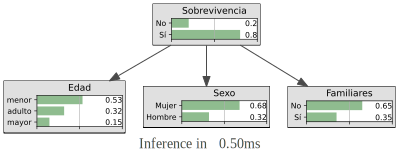

In [ ]:
gnb.showInference(bn)

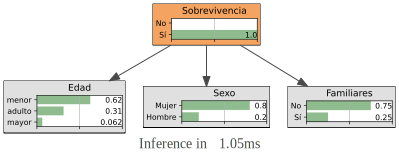

In [ ]:
#¿Quiénes tienen más probabilidades de sobrevir?
gnb.showInference(bn, evs={'Sobrevivencia':'Sí'})


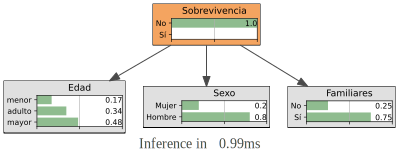

In [ ]:
#¿Quiénes tienen más probabilidades de no sobrevir?
gnb.showInference(bn, evs={'Sobrevivencia':'No'})

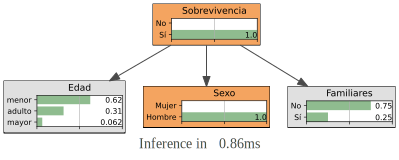

In [ ]:
#los hombres que sobrevivien ¿cómo son?
gnb.showInference(bn, evs={'Sobrevivencia':'Sí', 'Sexo':'Hombre'})


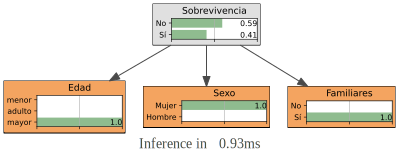

In [ ]:
#¿qué pasa con las mujeres mayores?
gnb.showInference(bn,size="10", evs={'Sexo':'Mujer', 'Edad':'mayor','Familiares':'Sí'})